# Phase 2 — Data Acquisition, Cleaning, and EDA (Online Retail II)

Goal: load the raw retail transactions dataset, perform **basic cleaning**, create a few **business-friendly features** (like total line item value), and run **exploratory analysis** that sets us up for modeling later (e.g., churn/retention, RFM, forecasting).

**Dataset**: Online Retail II (transaction-level e-commerce data).

> Tip: keep this notebook as your reusable template for any tabular ML project: *Load → Inspect → Clean → Save → EDA*.


In [1]:
# Core libraries
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display preferences
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("✅ Environment ready")


✅ Environment ready


## 1) Load the raw dataset
This cell tries a few common file locations and formats. Update the `DATA_DIR` if your project uses a different structure.

In [2]:
# ---- Path configuration (edit if needed) ----
PROJECT_ROOT = Path("..")  # assumes notebook is in /notebooks
DATA_DIR = PROJECT_ROOT / "data" / "raw"

# Candidate file names (csv/xlsx are common for this dataset)
candidates = [
    DATA_DIR / "online_retail_II.csv",
    DATA_DIR / "Online Retail II.csv",
    DATA_DIR / "online_retail_II.xlsx",
    DATA_DIR / "Online Retail II.xlsx",
    Path("online_retail_II.csv"),
    Path("online_retail_II.xlsx"),
]

raw_path = next((p for p in candidates if p.exists()), None)

if raw_path is None:
    raise FileNotFoundError(
        "Could not find the raw dataset. Tried:\n"
        + "\n".join(str(p.resolve()) for p in candidates)
    )

print(f"📄 Using file: {raw_path}")


📄 Using file: ..\data\raw\online_retail_II.csv


In [3]:
# ---- Reader: CSV or Excel ----
if raw_path.suffix.lower() == ".csv":
    df_raw = pd.read_csv(raw_path, encoding_errors="ignore")
elif raw_path.suffix.lower() in {".xlsx", ".xls"}:
    # Many versions have a single sheet; if yours has multiple, set sheet_name explicitly.
    df_raw = pd.read_excel(raw_path)
else:
    raise ValueError(f"Unsupported file type: {raw_path.suffix}")

print(f"Rows: {len(df_raw):,} | Columns: {df_raw.shape[1]}")
df_raw.head()


Rows: 1,067,371 | Columns: 8


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 2) Quick inspection
We check schema, missingness, duplicates, and a few sanity stats.

In [4]:
# Column overview
display(df_raw.info())


<class 'pandas.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  str    
 1   StockCode    1067371 non-null  str    
 2   Description  1062989 non-null  str    
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  str    
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 65.1 MB


None

In [5]:
# Missing values (count + %)
miss = (
    df_raw.isna()
    .sum()
    .to_frame("missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(df_raw) * 100).round(2))
    .sort_values("missing_count", ascending=False)
)
miss


,missing_count,missing_pct
Customer ID,243007,22.77
Description,4382,0.41
StockCode,0,0.00
Invoice,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
Price,0,0.00
Country,0,0.00


In [6]:
# Duplicate row count
dup_count = df_raw.duplicated().sum()
print(f"Duplicate rows: {dup_count:,} ({dup_count/len(df_raw)*100:.2f}%)")


Duplicate rows: 34,335 (3.22%)


In [7]:
# Peek at value ranges for likely numeric fields
numeric_like = [c for c in df_raw.columns if df_raw[c].dtype != "object"]
df_raw[numeric_like].describe().T


,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


## 3) Cleaning pipeline
We will:
1. Standardize column names (optional but helpful)
2. Parse dates
3. Remove cancelled/invalid rows (negative quantity/price)
4. Handle missing customer IDs (keep or drop depending on use case)
5. Create `total_price = quantity * price`

**Note**: cleaning rules vary by project. Here we choose conservative defaults for downstream churn/RFM analysis.

In [8]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Return a copy with normalized column names."""
    out = df.copy()
    out.columns = (
        out.columns
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^0-9a-zA-Z_]+", "", regex=True)
    )
    return out

df = standardize_columns(df_raw)

print("Columns after standardization:")
print(df.columns.tolist())


Columns after standardization:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer_ID', 'Country']


In [9]:
# Flexible column detection (dataset variants exist)
def pick_column(df: pd.DataFrame, options: list[str]) -> str:
    for c in options:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns were found: {options}")

col_invoice = pick_column(df, ["Invoice", "InvoiceNo", "InvoiceNo_", "InvoiceNo."])
col_stock = pick_column(df, ["StockCode", "Stock_Code", "StockCode_"])
col_desc  = pick_column(df, ["Description", "ItemDescription", "ProductDescription"])
col_qty   = pick_column(df, ["Quantity", "Qty"])
col_date  = pick_column(df, ["InvoiceDate", "Invoice_Date", "Date"])
col_price = pick_column(df, ["Price", "UnitPrice", "Unit_Price"])
col_cust  = pick_column(df, ["CustomerID", "Customer_ID", "CustomerId", "Customer_ID_"])
col_country = pick_column(df, ["Country"])

print("Detected columns:")
print({
    "invoice": col_invoice, "stock": col_stock, "desc": col_desc, "qty": col_qty,
    "date": col_date, "price": col_price, "customer": col_cust, "country": col_country
})


Detected columns:
{'invoice': 'Invoice', 'stock': 'StockCode', 'desc': 'Description', 'qty': 'Quantity', 'date': 'InvoiceDate', 'price': 'Price', 'customer': 'Customer_ID', 'country': 'Country'}


In [10]:
# Parse datetime safely
df[col_date] = pd.to_datetime(df[col_date], errors="coerce")

# Basic trimming for text fields
df[col_desc] = df[col_desc].astype(str).str.strip()

# Drop rows where date/quantity/price are missing (can't use them for most analytics)
before = len(df)
df = df.dropna(subset=[col_date, col_qty, col_price])
print(f"Dropped {before - len(df):,} rows with missing date/qty/price.")


Dropped 0 rows with missing date/qty/price.


In [11]:
# Remove cancelled invoices if they follow the common 'C' prefix pattern.
# (Some versions use negative quantities only; we handle both.)
invoice_as_str = df[col_invoice].astype(str)
cancelled_mask = invoice_as_str.str.startswith(("C", "c"))

# Keep a copy of cancelled count for reporting
cancelled_rows = int(cancelled_mask.sum())

# Remove obviously invalid values
invalid_mask = (df[col_qty] <= 0) | (df[col_price] <= 0)

print(f"Cancelled rows (prefix C*): {cancelled_rows:,}")
print(f"Rows with non-positive qty/price: {int(invalid_mask.sum()):,}")

df_clean = df.loc[~cancelled_mask & ~invalid_mask].copy()
print(f"Remaining rows after removals: {len(df_clean):,}")


Cancelled rows (prefix C*): 19,494
Rows with non-positive qty/price: 25,700
Remaining rows after removals: 1,041,670


In [12]:
# Customer ID handling:
# For churn/RFM, CustomerID is crucial. We'll drop missing IDs by default.
# If your goal is item-level sales analysis, you might keep them instead.
before = len(df_clean)
df_clean = df_clean.dropna(subset=[col_cust])
print(f"Dropped {before - len(df_clean):,} rows with missing customer id.")


Dropped 236,121 rows with missing customer id.


In [13]:
# Convert CustomerID to integer-like (safe)
# Some datasets store it as float; this keeps it clean for joins/groupby.
df_clean[col_cust] = df_clean[col_cust].astype("int64")

# Compute total line value
df_clean["TotalPrice"] = df_clean[col_qty] * df_clean[col_price]

# Remove extreme outliers for EDA only? (we'll just flag here, not drop)
print(df_clean[["TotalPrice", col_qty, col_price]].describe().T)
df_clean.head()


               count       mean         std    min   25%    50%    75%       max
TotalPrice  805549.0  22.026505  224.041928  0.001  4.95  11.85  19.50  168469.6
Quantity    805549.0  13.290522  143.634088  1.000  2.00   5.00  12.00   80995.0
Price       805549.0   3.206561   29.199173  0.001  1.25   1.95   3.75   10953.5


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


## 4) Save the cleaned dataset
We save a processed CSV so future notebooks (RFM, churn labeling, modeling) can start from a consistent baseline.

In [14]:
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

cleaned_path = PROCESSED_DIR / "online_retail_cleaned.csv"
df_clean.to_csv(cleaned_path, index=False)

print(f"✅ Saved cleaned dataset to: {cleaned_path.resolve()}")


✅ Saved cleaned dataset to: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\data\processed\online_retail_cleaned.csv


## 5) EDA on cleaned data
We answer a few practical questions:
- What time period does the data cover?
- How do transactions and revenue trend over months?
- What do quantity/price/total distributions look like?
- Which countries drive activity and revenue?
- How many unique customers do we have?


In [15]:
df_eda = pd.read_csv(cleaned_path)
df_eda[col_date] = pd.to_datetime(df_eda[col_date], errors="coerce")

print(f"EDA rows: {len(df_eda):,}")
df_eda.head()


EDA rows: 805,549


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [16]:
# Dataset time range
start_dt = df_eda[col_date].min()
end_dt = df_eda[col_date].max()
print(f"Time span: {start_dt.date()} → {end_dt.date()}")


Time span: 2009-12-01 → 2011-12-09


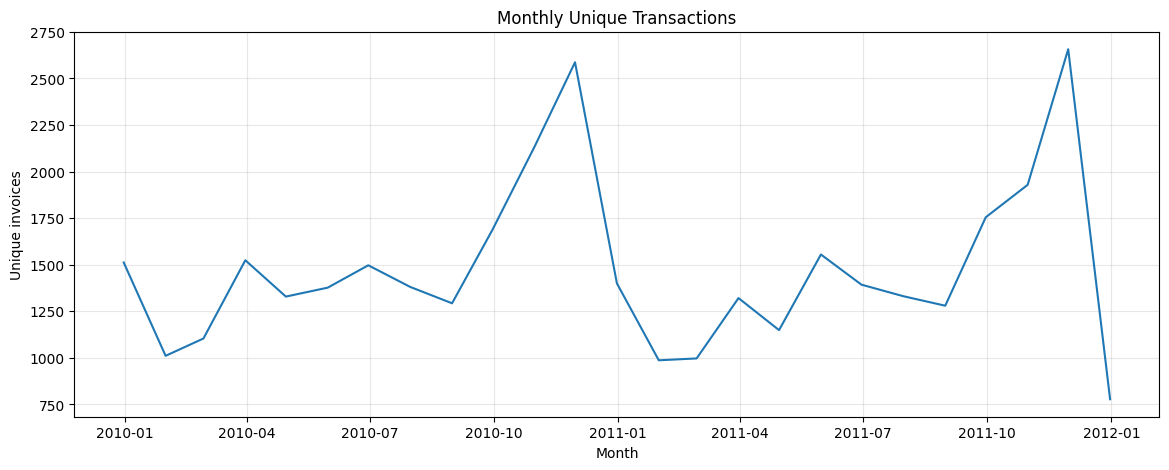

In [20]:
# Monthly unique transactions
monthly_txn = (
    df_eda
    .set_index(col_date)
    .resample("ME")[col_invoice]
    .nunique()
)

plt.figure(figsize=(14, 5))
plt.plot(monthly_txn.index, monthly_txn.values)
plt.title("Monthly Unique Transactions")
plt.xlabel("Month")
plt.ylabel("Unique invoices")
plt.grid(True, alpha=0.3)
plt.show()


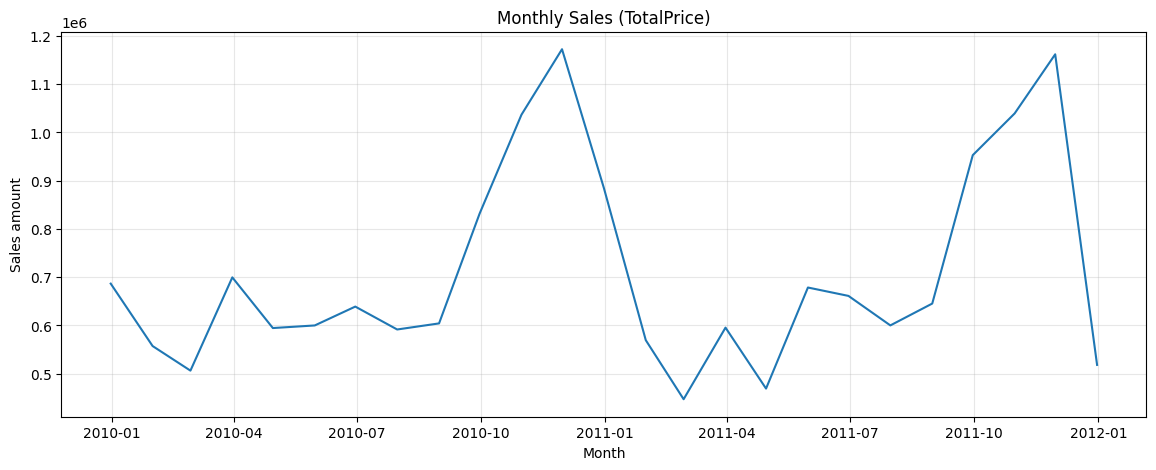

In [22]:
# Monthly total sales
monthly_sales = (
    df_eda
    .set_index(col_date)
    .resample("ME")["TotalPrice"]
    .sum()
)

plt.figure(figsize=(14, 5))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title("Monthly Sales (TotalPrice)")
plt.xlabel("Month")
plt.ylabel("Sales amount")
plt.grid(True, alpha=0.3)
plt.show()


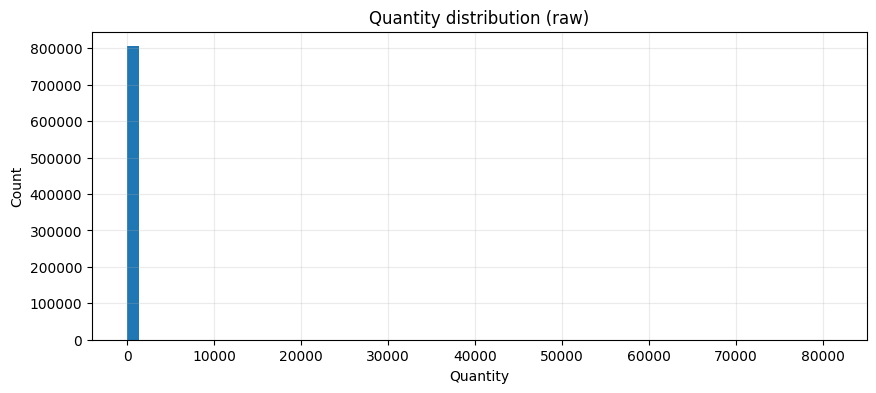

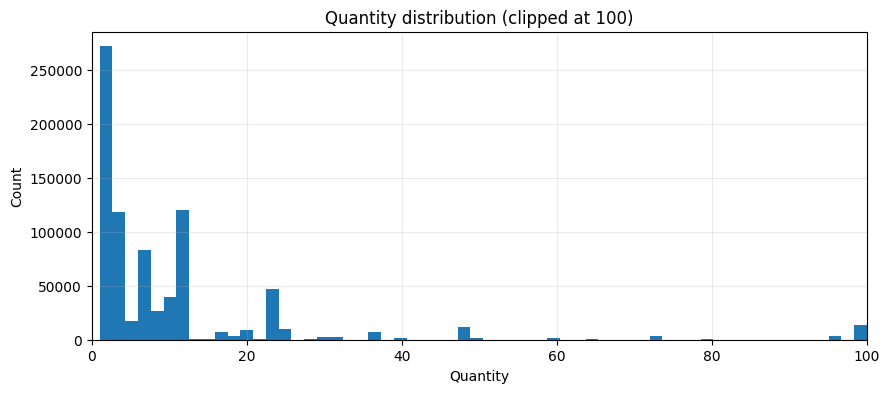

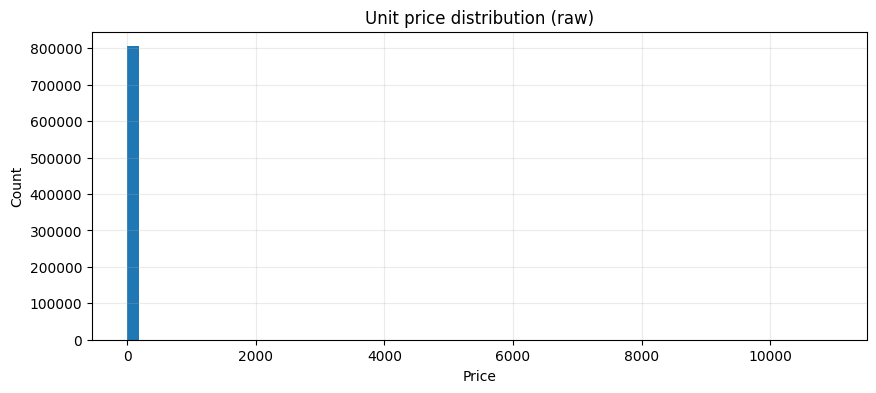

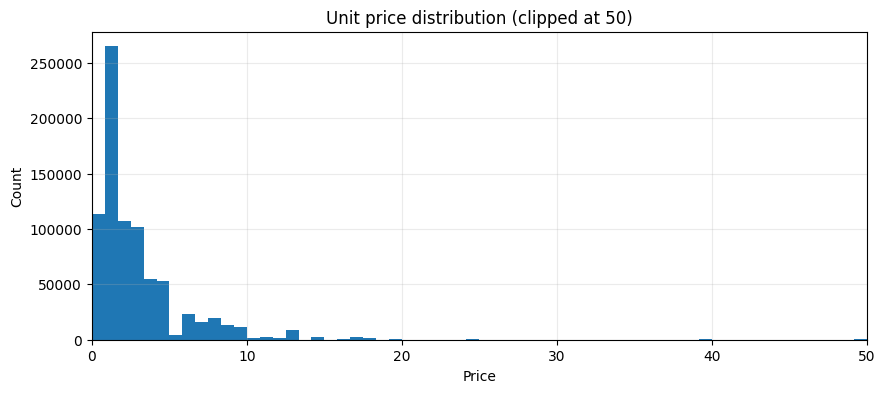

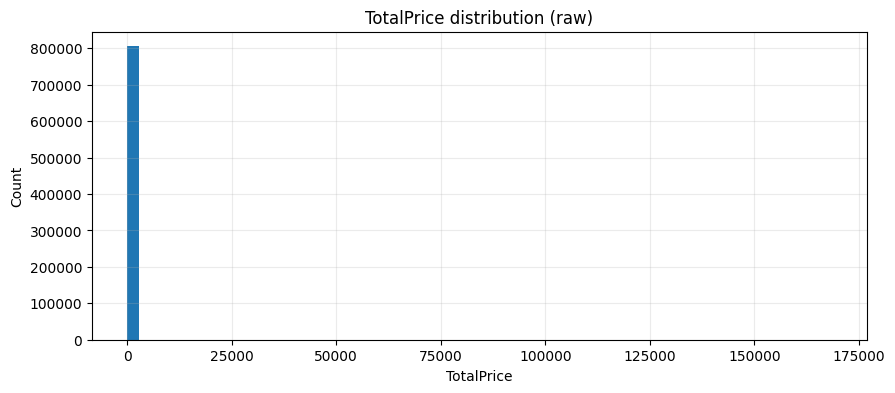

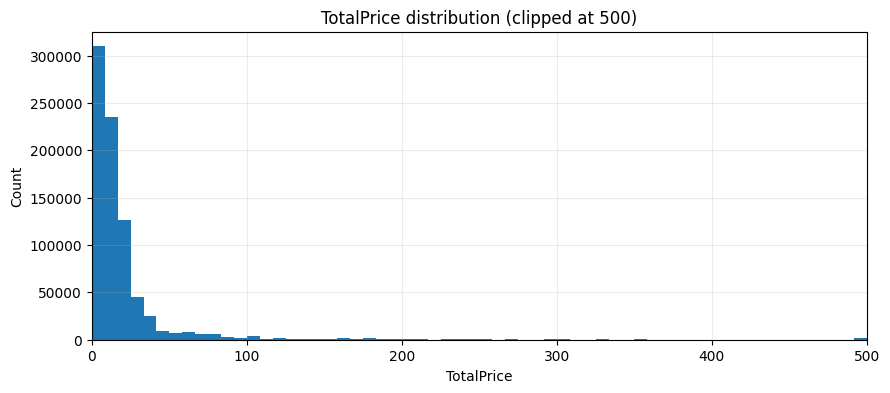

In [23]:
# Distribution plots (trim to avoid charts dominated by outliers)
def plot_hist(series: pd.Series, title: str, xlim=None, bins=60):
    plt.figure(figsize=(10, 4))
    plt.hist(series.dropna().values, bins=bins)
    if xlim:
        plt.xlim(*xlim)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.grid(True, alpha=0.25)
    plt.show()

plot_hist(df_eda[col_qty], "Quantity distribution (raw)")
plot_hist(df_eda[col_qty].clip(upper=100), "Quantity distribution (clipped at 100)", xlim=(0, 100))

plot_hist(df_eda[col_price], "Unit price distribution (raw)")
plot_hist(df_eda[col_price].clip(upper=50), "Unit price distribution (clipped at 50)", xlim=(0, 50))

plot_hist(df_eda["TotalPrice"], "TotalPrice distribution (raw)")
plot_hist(df_eda["TotalPrice"].clip(upper=500), "TotalPrice distribution (clipped at 500)", xlim=(0, 500))


In [24]:
# Top countries by transaction count
top_countries_txn = (
    df_eda
    .groupby(col_country)[col_invoice]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)
top_countries_txn


Country
United Kingdom    33541
Germany             789
France              614
EIRE                567
Netherlands         228
Spain               154
Belgium             149
Sweden              104
Australia            95
Portugal             93
Name: Invoice, dtype: int64

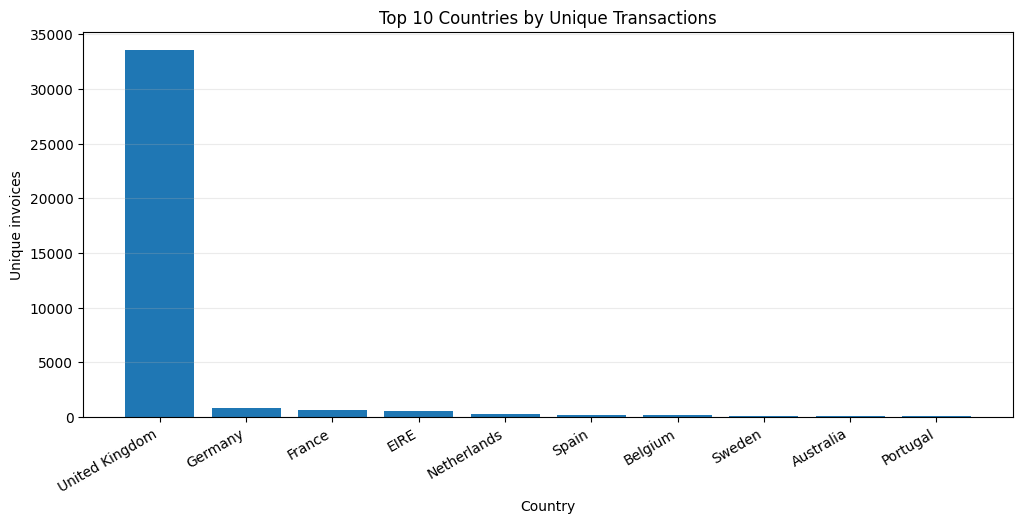

In [25]:
plt.figure(figsize=(12, 5))
plt.bar(top_countries_txn.index.astype(str), top_countries_txn.values)
plt.title("Top 10 Countries by Unique Transactions")
plt.xlabel("Country")
plt.ylabel("Unique invoices")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.25)
plt.show()


In [26]:
# Top countries by total sales
top_countries_sales = (
    df_eda
    .groupby(col_country)["TotalPrice"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_countries_sales


Country
United Kingdom    1.472315e+07
EIRE              6.216311e+05
Netherlands       5.542323e+05
Germany           4.312625e+05
France            3.552575e+05
Australia         1.699681e+05
Spain             1.091785e+05
Switzerland       1.003653e+05
Sweden            9.154972e+04
Denmark           6.986219e+04
Name: TotalPrice, dtype: float64

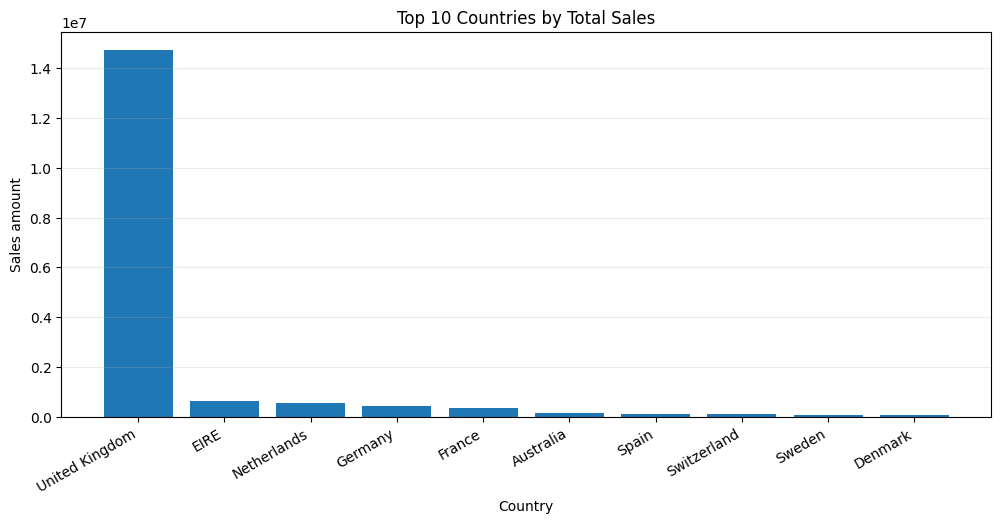

In [27]:
plt.figure(figsize=(12, 5))
plt.bar(top_countries_sales.index.astype(str), top_countries_sales.values)
plt.title("Top 10 Countries by Total Sales")
plt.xlabel("Country")
plt.ylabel("Sales amount")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.25)
plt.show()


In [28]:
# Unique customers
n_customers = df_eda[col_cust].nunique()
n_invoices = df_eda[col_invoice].nunique()
print(f"Unique customers: {n_customers:,}")
print(f"Unique invoices:  {n_invoices:,}")


Unique customers: 5,878
Unique invoices:  36,969


### Graph 1: Missing Values Heatmap

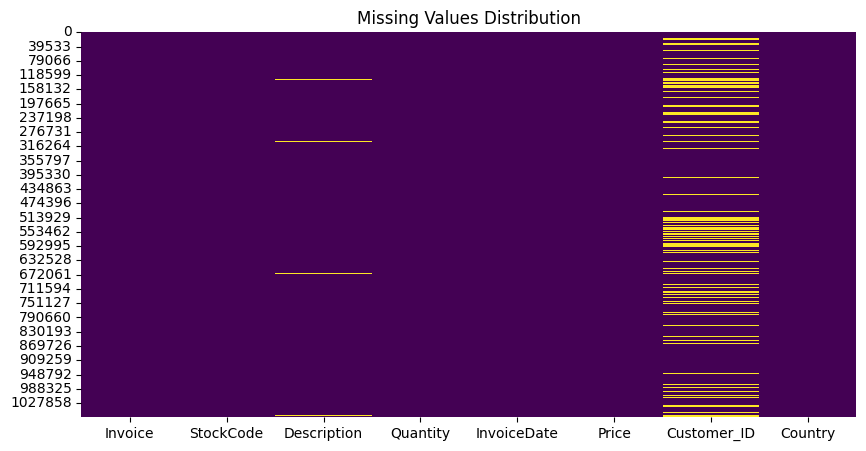

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Distribution")
plt.show()

#  Interview angle:

### “This helps identify columns requiring imputation or removal.”

### Numerical Feature Distribution (Histogram)

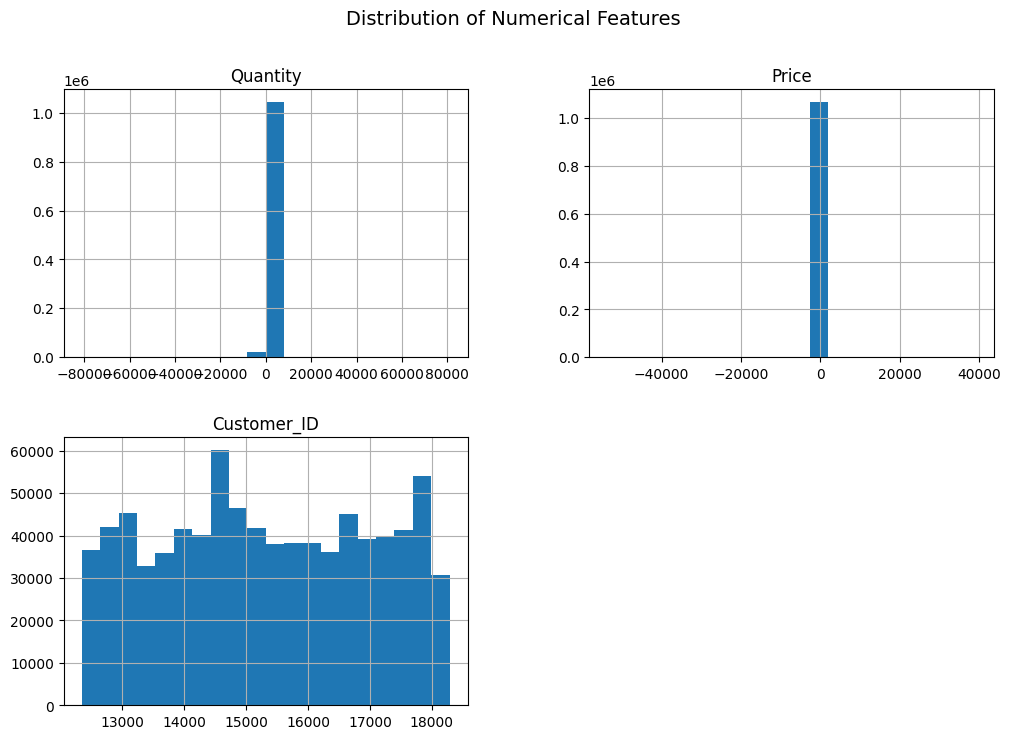

In [30]:
numeric_cols = df.select_dtypes(include="number").columns

df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.show()

### Interview angle:

## “Used to detect skewness, outliers, and scaling needs.”

## Correlation Heatmap

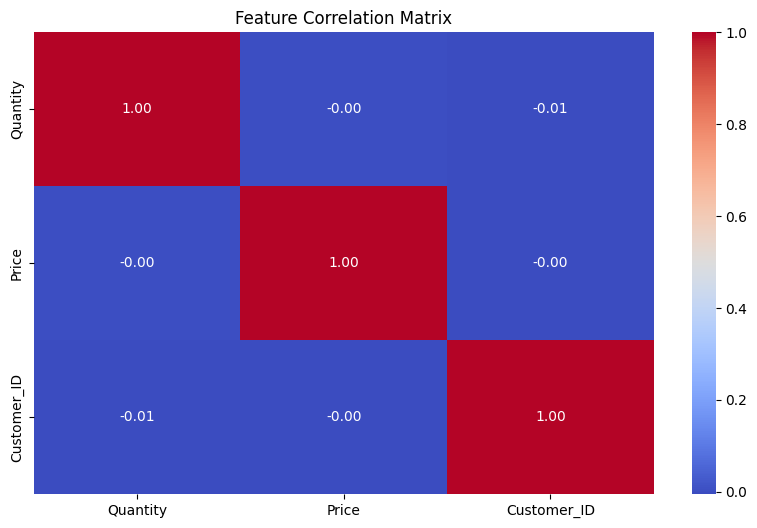

In [31]:
plt.figure(figsize=(10, 6))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

## Interview angle:

### “Helps identify multicollinearity and redundant features.”

### Target Variable Analysis (Bar / Count Plot)
## Use this only if you have a target column (classification or churn-like problem)

## Interview angle:

## “Used to detect class imbalance before model training.”

## Exploratory Data Analysis (EDA)

The following visualizations are created to:
- Understand data quality
- Analyze feature distributions
- Identify correlations
- Detect class imbalance

These insights guide preprocessing, feature engineering, and model selection.

## 6) Interview questions (based on this notebook)
Use these to practice explaining your work end-to-end.

### Data understanding
1. What is the unit of analysis in this dataset (row meaning), and why does it matter for modeling?
2. Which columns would you trust the least at first glance, and how would you validate them?
3. What are examples of data leakage risks in a transaction dataset like this?

### Cleaning & assumptions
4. Why did you remove cancelled invoices and rows with negative quantity/price? When might you keep them?
5. Customer IDs are missing for some rows — what are your options, and how do they change the business question?
6. How do you decide whether a value is an outlier vs a valid extreme purchase?

### Feature engineering
7. Why is `TotalPrice = Quantity × Price` a better feature than using only Quantity or Price?
8. What additional features would you create for churn/retention modeling (hint: RFM, tenure, inter-purchase time)?

### EDA insights
9. If monthly sales spikes appear, what hypotheses would you test (seasonality, campaigns, data issues)?
10. How would you check whether the top-selling countries are genuinely high-value or just have more customers?

### Next steps (modeling)
11. Define churn for an e-commerce retail dataset. What churn window would you choose and why?
12. How would you split train/test for time-series-like customer behavior to avoid leakage?
13. Which evaluation metrics fit churn prediction, and how would you handle class imbalance?
